<div style="display:fill;
           background-color:#F2E5E5;
           letter-spacing:0.5px;border-bottom: 2px solid black;">
<img src="https://raw.githubusercontent.com/IqmanS/Machine-Learning-Notebooks/refs/heads/main/Land_Cover_EUROSAT/thumb.jpg">
<H1 style="padding: 20px; color:black; font-weight:600; font-family: 'Garamond', 'Lucida Sans', sans-serif; text-align: center; font-size: 38px;">Land-Cover Classification with EuroSAT Dataset </H1>
</div>


In [1]:
import os
import shutil
import random
from tqdm import tqdm

import numpy as np
import pandas as pd
import re
import json
import shap

import PIL
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
# import imutils
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Flatten, Activation, Dense, MaxPooling2D, Dropout#, RandomRotation, RandomFlip, RandomContrast
from tensorflow.keras import Sequential

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
# from keras.models import Model
# from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# from keras.optimizers import Adam

from tensorflow.keras.applications import VGG16, VGG19, MobileNetV2 
from tensorflow.keras.applications import ResNet50, ResNet50V2, ResNet152V2, ResNet101V2
from tensorflow.keras.applications import InceptionV3, Xception

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score, accuracy_score, f1_score, precision_score, recall_score

Using TensorFlow backend.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
#   try:
#     tf.config.set_visible_devices(gpus[0], 'GPU')
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
#   except RuntimeError as e:
#     # Visible devices must be set before GPUs have been initialized
#     print(e)

# Data Exploration

In [4]:
IMAGE_DIR = "/kaggle/input/eurosat-rgb/2750"
LABELS = os.listdir(IMAGE_DIR)
print(LABELS)

['SeaLake', 'Highway', 'River', 'Pasture', 'Industrial', 'Residential', 'PermanentCrop', 'AnnualCrop', 'Forest', 'HerbaceousVegetation']


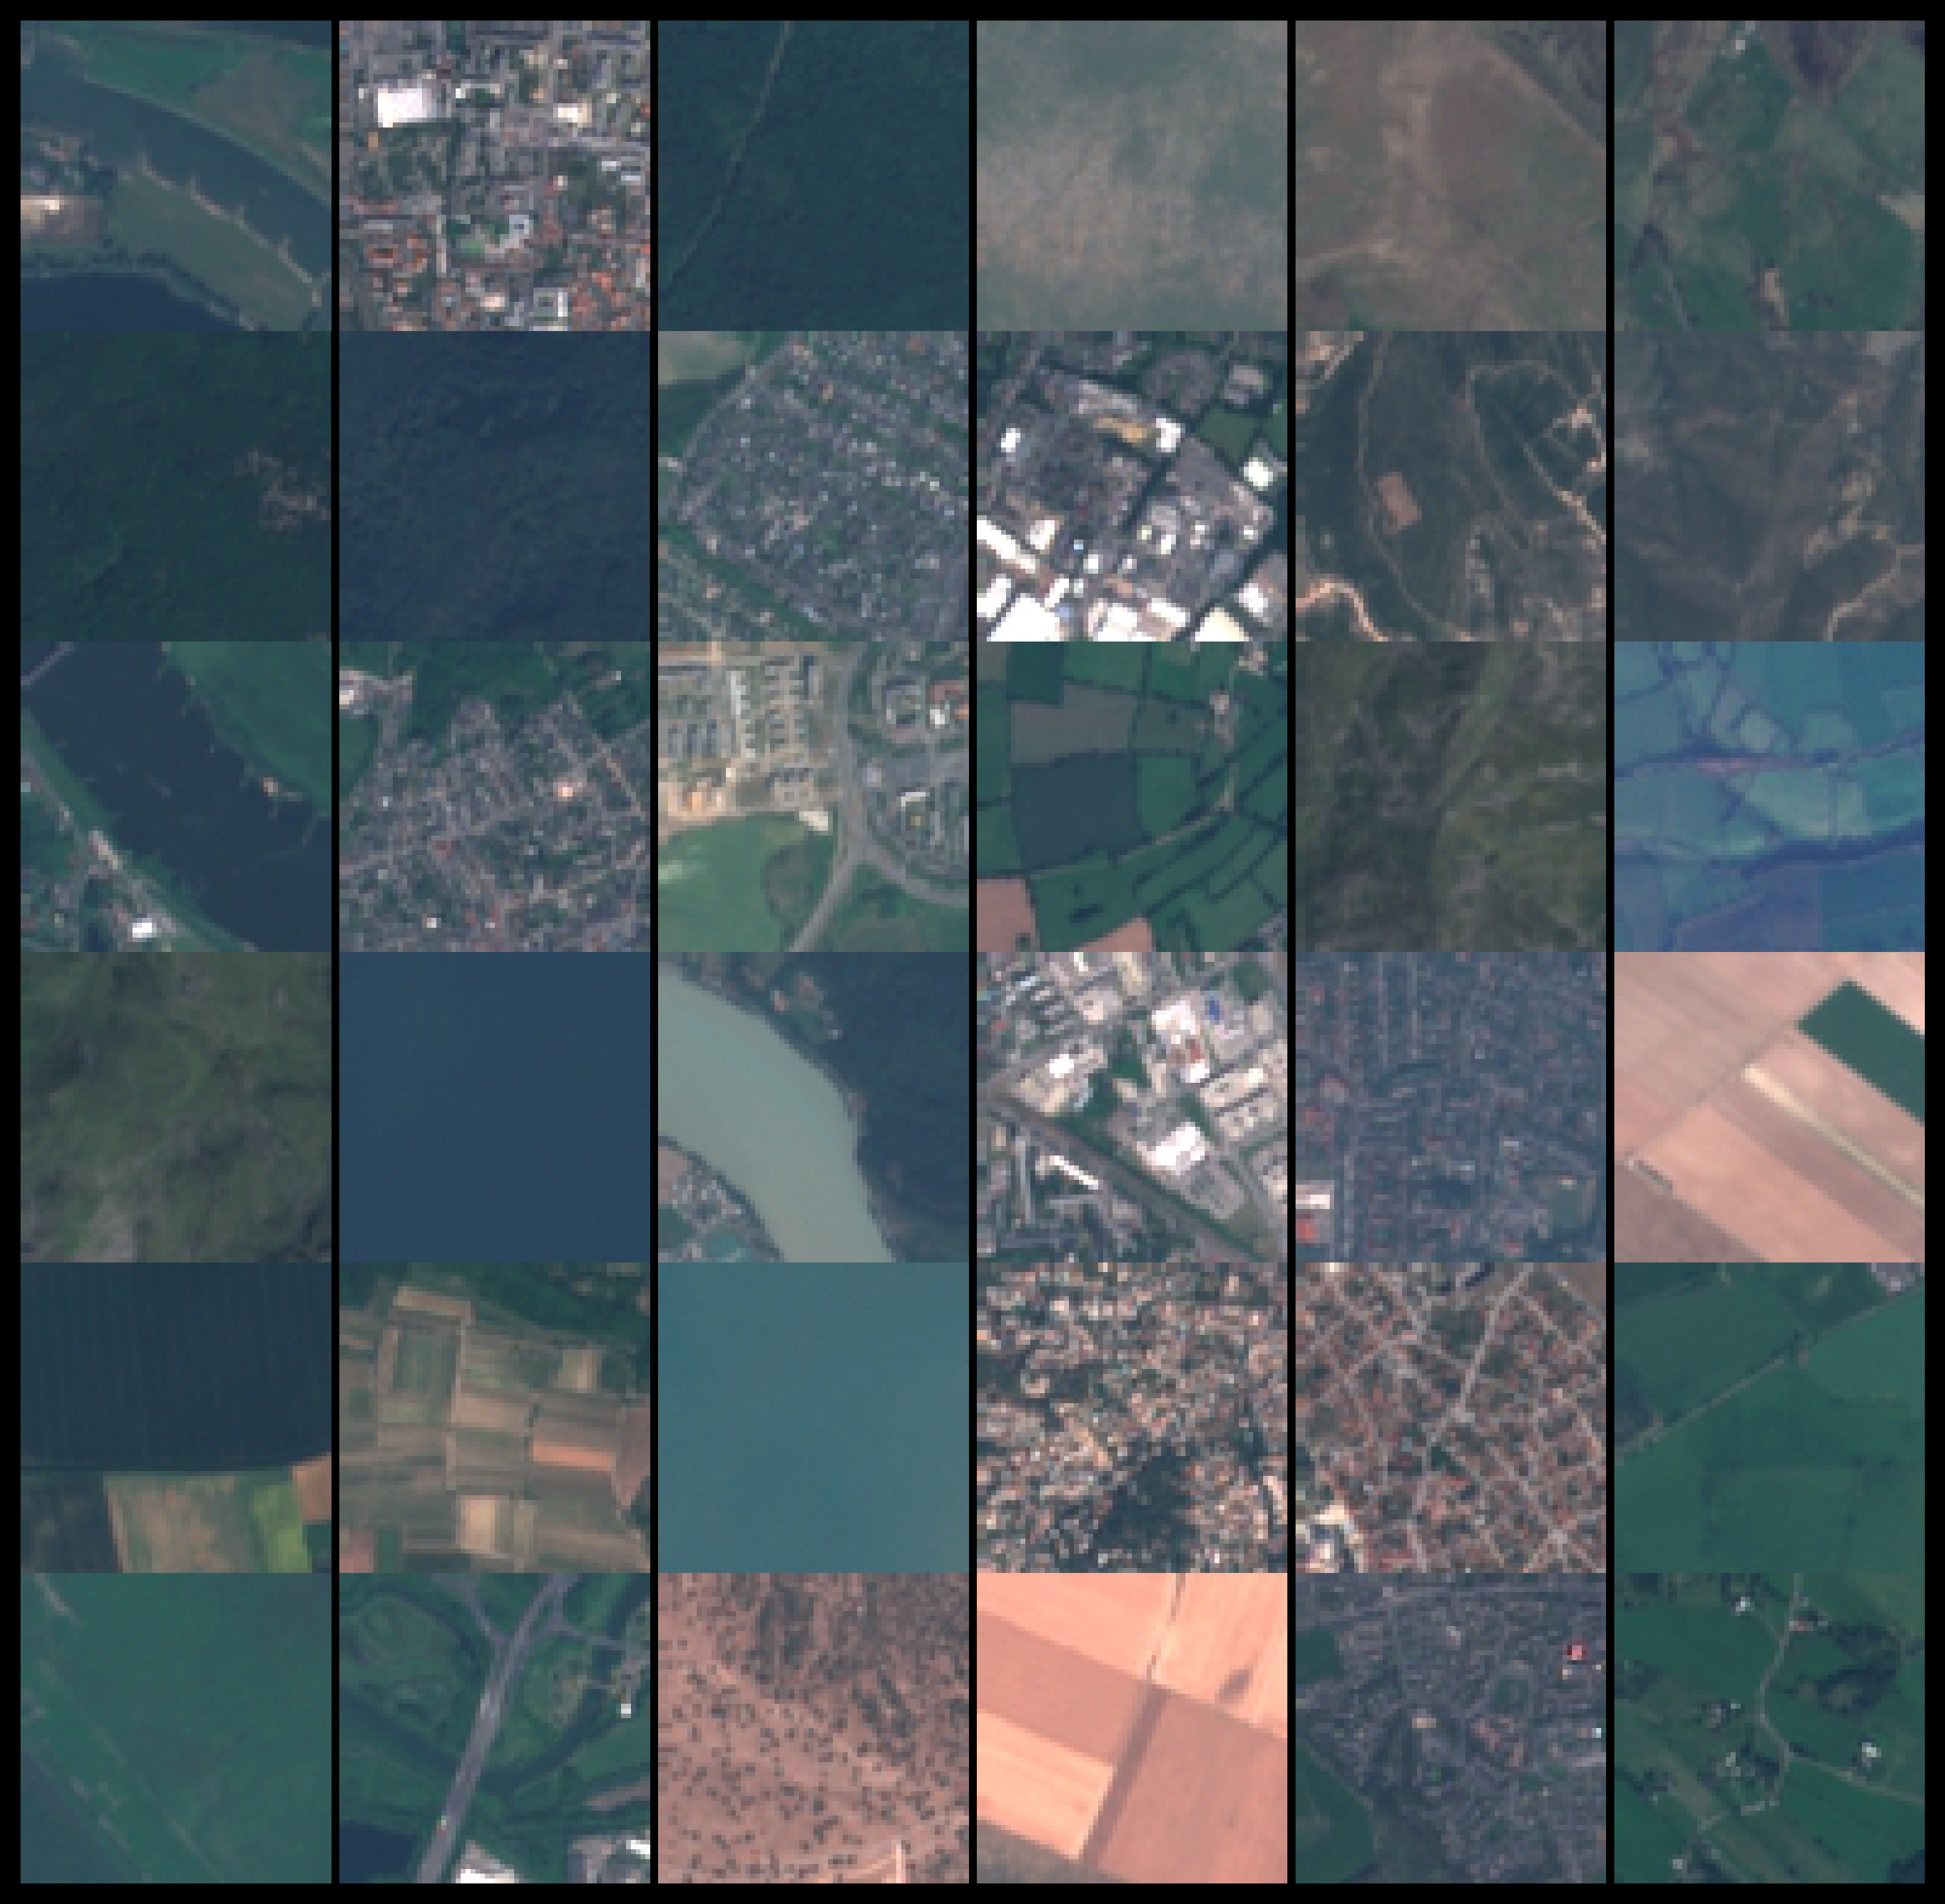

In [5]:
fig, axs = plt.subplots(6, 6,figsize=(12,12),dpi=500)
for i in range(6):
    for j in range(6):
        label = np.random.choice(LABELS)
        number = np.random.randint(1000,2000)
        img_path = IMAGE_DIR+"/"+label+"/"+label+"_"+str(number)+".jpg"
        img = PIL.Image.open(img_path, 'r')
        axs[i, j].imshow(img)
        axs[i, j].axis("off")

for ax in axs.ravel():
    ax.set_axis_off();
    
plt.subplots_adjust(wspace=0, hspace=0);
# plt.tight_layout();
fig.patch.set_facecolor('black')
plt.savefig("image.png");
plt.show();

In [6]:
# def augment_data(file_dir, save_to_dir, n_generated_samples = 2):
#     data_gen = ImageDataGenerator(rotation_range=10, 
#                                   width_shift_range=0.1, 
#                                   height_shift_range=0.1, 
#                                   shear_range=0.1, 
#                                   brightness_range=(0.5, 1.0),
#                                   horizontal_flip=True, 
#                                   vertical_flip=True, 
#                                   fill_mode='nearest'
#                                  )

#     for filename in listdir(file_dir):
#         image = cv2.imread(file_dir + '/' + filename)
#         # reshape the image
#         image = image.reshape((1,)+image.shape)
#         save_prefix = 'aug_' + filename[:-4]
#         i=0
#         for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
#                 i += 1
#                 if i > n_generated_samples:
#                     break

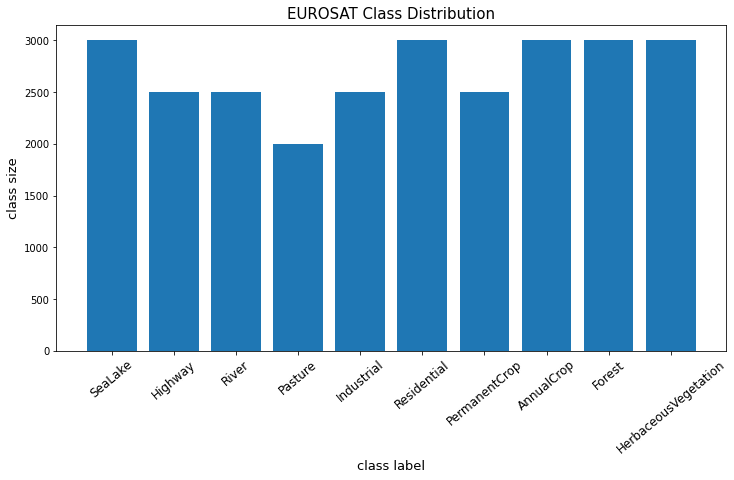

In [7]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(IMAGE_DIR, l)))

    
plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

# Data Preprocessing

In [8]:
# SET SEED
np.random.seed(6)
seed = np.random.randint(123)
print(seed)

10


In [9]:
TRAIN_DIR = '../working/training'
TEST_DIR = '../working/testing'
BATCH_SIZE = 128
NUM_CLASSES = len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'
TEST_SIZE = 0.25

for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)

for l in LABELS:
    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))

In [10]:
# # map each image path to their class label in 'data'
# data = {}

# for l in LABELS:
#     for img in os.listdir(IMAGE_DIR+'/'+l):
#         data.update({os.path.join(IMAGE_DIR, l, img): l})

# X = pd.Series(list(data.keys()))
# y = pd.get_dummies(pd.Series(data.values()))

# split = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=seed)

# # split the list of image paths
# for train_idx, test_idx in split.split(X, y):
    
#     train_paths = X[train_idx]
#     test_paths = X[test_idx]

#     # define a new path for each image depending on training or testing
#     new_train_paths = [re.sub('\.\.\/input\/2750', '../working/training', i) for i in train_paths]
#     new_test_paths = [re.sub('\.\.\/input\/2750', '../working/testing', i) for i in test_paths]

#     train_path_map = list((zip(train_paths, new_train_paths)))
#     test_path_map = list((zip(test_paths, new_test_paths)))
    
#     # move the files
#     # print("moving training files..")
#     for i in tqdm(train_path_map,desc = "Moving Training Data"):
#         if not os.path.exists(i[1]):
#             if not os.path.exists(re.sub('training', 'testing', i[1])):
#                 shutil.copy(i[0], i[1])
    
#     # print("moving testing files..")
#     for i in tqdm(test_path_map,desc = "Moving Testing Data"):
#         if not os.path.exists(i[1]):
#             if not os.path.exists(re.sub('training', 'testing', i[1])):
#                 shutil.copy(i[0], i[1])

In [11]:
TRAIN_DIR = "/kaggle/input/lulc-eurosat/training"
TEST_DIR  = "/kaggle/input/lulc-eurosat/testing"

# Create a ImageDataGenerator Instance which can be used for data augmentation

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=(0.5, 1.0),
    horizontal_flip=True, 
    vertical_flip=True, 
    fill_mode='nearest'
)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=True,
    seed=seed
)

# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=seed
)

pred_generator = test_gen.flow_from_directory(  #no batches
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=seed
)

Found 20250 images belonging to 10 classes.
Found 6750 images belonging to 10 classes.
Found 6750 images belonging to 10 classes.


In [12]:
print(train_generator.class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [13]:
np.save('class_indices', train_generator.class_indices)

# Building Deep Learning Models

1. Custom CNN
2. MobileNetV2
3. ResNet101V2


In [14]:
N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

In [15]:
def plot_history(history):
       
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.title("Acc vs Val Acc")
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.title("Loss vs Val Loss")
    
    plt.show();

In [16]:
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=50,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,
                              patience=20, min_lr=0.0001)

## 1. Custom CNN Model

In [17]:
def build_model(input_shape):
    try:
        model = tf.keras.models.load_model("/kaggle/input/lulc-eurosat/custom_model.keras")
    except:
        model = Sequential()
        model.add(Input(input_shape))
        model.add(Conv2D(16,5,activation="relu"))
        model.add(MaxPooling2D(2,2))
        model.add(Conv2D(32,5,activation="relu"))
        model.add(Conv2D(32,5,activation="relu"))
        model.add(MaxPooling2D(2,2))
        model.add(Conv2D(64,7,activation="relu"))
        model.add(MaxPooling2D(2,2))
        model.add(Flatten())
        model.add(Dense(100))
        model.add(Dropout(0.2))
        model.add(Dense(len(LABELS),activation="softmax"))
    return model

custom_model = build_model(INPUT_SHAPE)

train_generator.reset()
test_generator.reset()

custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
custom_model_history = custom_model.fit_generator(train_generator, steps_per_epoch=N_STEPS, epochs=200,
                                                  callbacks=[early_stop, reduce_lr],
                                                  validation_data=test_generator, validation_steps=N_VAL_STEPS)

Train for 158 steps, validate for 52 steps
Epoch 1/200
158/158 [==============================] - 111s 702ms/step - loss: 0.5098 - accuracy: 0.8356 - val_loss: 0.4252 - val_accuracy: 0.8625
Epoch 2/200
158/158 [==============================] - 50s 320ms/step - loss: 0.4259 - accuracy: 0.8533 - val_loss: 0.4438 - val_accuracy: 0.8550
Epoch 3/200
158/158 [==============================] - 51s 324ms/step - loss: 0.4459 - accuracy: 0.8460 - val_loss: 0.3887 - val_accuracy: 0.8645
Epoch 4/200
158/158 [==============================] - 51s 322ms/step - loss: 0.4463 - accuracy: 0.8494 - val_loss: 0.4617 - val_accuracy: 0.8463
Epoch 5/200
158/158 [==============================] - 77s 487ms/step - loss: 0.4585 - accuracy: 0.8469 - val_loss: 0.3714 - val_accuracy: 0.8678
Epoch 6/200
158/158 [==============================] - 115s 728ms/step - loss: 0.4294 - accuracy: 0.8570 - val_loss: 0.3770 - val_accuracy: 0.8730
Epoch 7/200
158/158 [==============================] - 53s 334ms/step - loss: 0

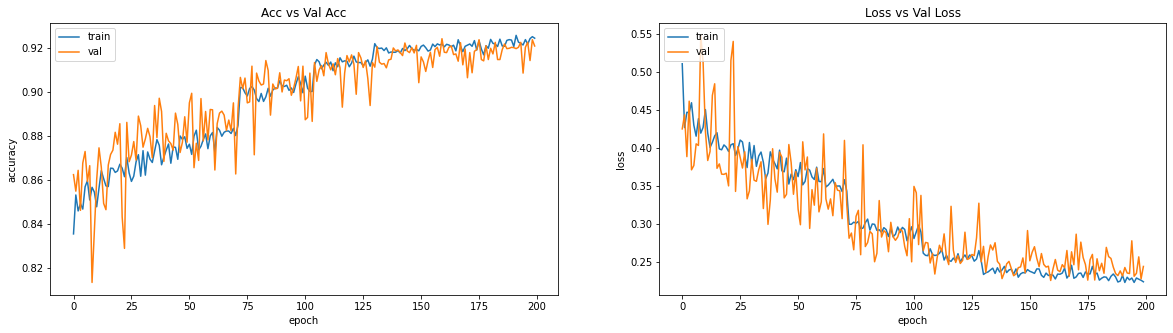

In [18]:
custom_model.save('custom_model.keras')
plot_history(custom_model_history)

# 2. Transfer Learning MobileNetV2 

In [19]:
# from keras.models import Model
# from keras.layers import Dense, Dropout, Flatten
# from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# from keras.optimizers import Adam

In [20]:
def build_mobilenet(input_shape, fine_tune=None):
    try:
        model = tf.keras.models.load_model("/kaggle/input/lulc-eurosat/mobilenet.keras")
    except:
        conv_base = MobileNetV2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        base_model = conv_base.output
        base_model = Flatten()(base_model)
        base_model = Dense(1000)(base_model)
        base_model = Dropout(0.2)(base_model)
        output_layer = Dense(len(LABELS),activation="softmax")(base_model) #o/p layer
        model = Model(inputs=conv_base.input, outputs=output_layer)
        if type(fine_tune) == int:
            for layer in conv_base.layers[fine_tune:]: layer.trainable = True
        else:
            for layer in conv_base.layers: layer.trainable = False
    return model

mobilenet = build_mobilenet(INPUT_SHAPE,20)

train_generator.reset()
test_generator.reset()

mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mobilenet_history = mobilenet.fit_generator(train_generator, steps_per_epoch=N_STEPS, epochs=200,
                                            callbacks=[early_stop, reduce_lr],
                                            validation_data=test_generator, validation_steps=N_VAL_STEPS)

Train for 158 steps, validate for 52 steps
Epoch 1/200
158/158 [==============================] - 56s 357ms/step - loss: 0.1928 - accuracy: 0.9352 - val_loss: 1.1377 - val_accuracy: 0.7722
Epoch 2/200
158/158 [==============================] - 51s 321ms/step - loss: 0.1696 - accuracy: 0.9429 - val_loss: 2.2898 - val_accuracy: 0.7207
Epoch 3/200
158/158 [==============================] - 53s 334ms/step - loss: 0.1494 - accuracy: 0.9504 - val_loss: 1.9224 - val_accuracy: 0.7381
Epoch 4/200
158/158 [==============================] - 51s 322ms/step - loss: 0.1410 - accuracy: 0.9539 - val_loss: 0.9724 - val_accuracy: 0.8508
Epoch 5/200
158/158 [==============================] - 51s 320ms/step - loss: 0.1340 - accuracy: 0.9542 - val_loss: 1.2006 - val_accuracy: 0.8098
Epoch 6/200
158/158 [==============================] - 51s 326ms/step - loss: 0.1313 - accuracy: 0.9564 - val_loss: 2.6080 - val_accuracy: 0.7142
Epoch 7/200
158/158 [==============================] - 52s 330ms/step - loss: 0.1

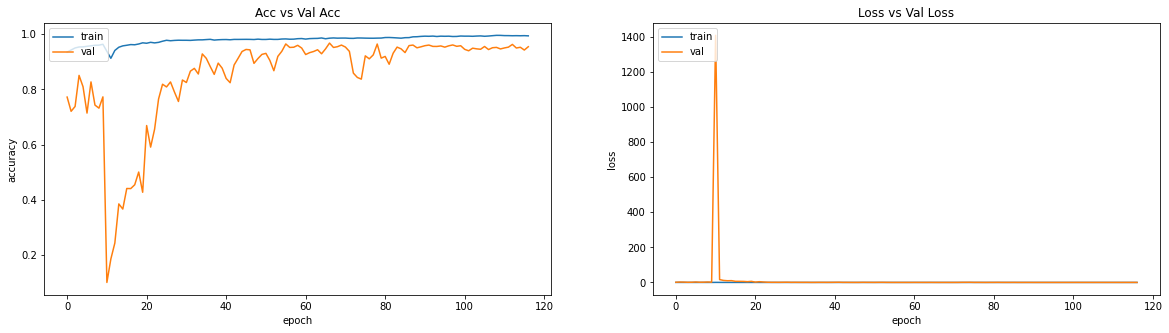

In [21]:
mobilenet.save('mobilenet.keras')
plot_history(mobilenet_history)

# 3. Transfer Learning ResNet101V2 

In [22]:
def build_resnet101(input_shape ,fine_tune=None):
    try:
        model = tf.keras.models.load_model("/kaggle/input/lulc-eurosat/resnet.keras")
    except:
        conv_base = ResNet101V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        base_model = conv_base.output
        base_model = Flatten()(base_model)
        base_model = Dense(1000)(base_model)
        base_model = Dropout(0.2)(base_model)
        output_layer = Dense(len(LABELS),activation="softmax")(base_model) #o/p layer
        model = Model(inputs=conv_base.input, outputs=output_layer)
    
        if type(fine_tune) == int:
            for layer in conv_base.layers[fine_tune:]: layer.trainable = True
        else:
            for layer in conv_base.layers: layer.trainable = False
        
    return model

resnet = build_resnet101(INPUT_SHAPE,20)

train_generator.reset()
test_generator.reset()

resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
resnet_history = resnet.fit_generator(train_generator, steps_per_epoch=N_STEPS, epochs=200,
                                      callbacks=[early_stop, reduce_lr],
                                      validation_data=test_generator, validation_steps=N_VAL_STEPS)

Train for 158 steps, validate for 52 steps
Epoch 1/200
158/158 [==============================] - 65s 414ms/step - loss: 0.6507 - accuracy: 0.8072 - val_loss: 5.2759 - val_accuracy: 0.2408
Epoch 2/200
158/158 [==============================] - 54s 344ms/step - loss: 0.6782 - accuracy: 0.8155 - val_loss: 350506.8763 - val_accuracy: 0.1600
Epoch 3/200
158/158 [==============================] - 54s 341ms/step - loss: 1.1257 - accuracy: 0.6403 - val_loss: 1.5307 - val_accuracy: 0.4501
Epoch 4/200
158/158 [==============================] - 87s 549ms/step - loss: 0.9219 - accuracy: 0.7194 - val_loss: 1604.1180 - val_accuracy: 0.3947
Epoch 5/200
158/158 [==============================] - 59s 373ms/step - loss: 0.8700 - accuracy: 0.7138 - val_loss: 1.1838 - val_accuracy: 0.5802
Epoch 6/200
158/158 [==============================] - 55s 348ms/step - loss: 0.6162 - accuracy: 0.7765 - val_loss: 1.0309 - val_accuracy: 0.6211
Epoch 7/200
158/158 [==============================] - 55s 348ms/step - l

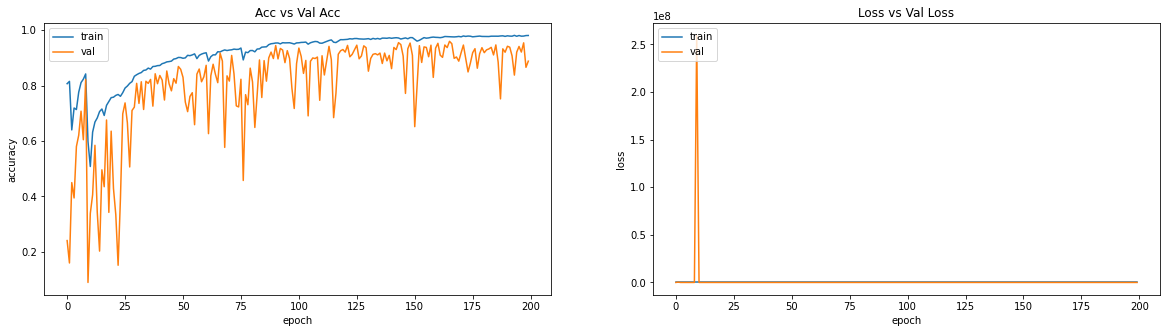

In [23]:
resnet.save('resnet.keras')
plot_history(resnet_history)

# Evaluation

In [24]:
def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)
    
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds), 
                            columns=class_labels,
                            index=class_labels)    
    accuracy = accuracy_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds,average='macro')
    precision = precision_score(y_true, y_preds,average='macro')
    recall = recall_score(y_true, y_preds,average='macro')
    
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")    
    print(f"Precision Score: {precision}")
    print(f"Recall Score: {recall}")  
    return results, conf_mat

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 12))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = np.argmax(y_preds[idx])
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))    

## Evaluating Custom CNN Model

In [25]:
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
pred_generator.reset()

predictions = custom_model.predict_generator(pred_generator, steps=len(pred_generator.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = pred_generator.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Accuracy: 0.9182222222222223
F1 Score: 0.9174777436463106
Precision Score: 0.9193712697269287
Recall Score: 0.9167196584514438


Precision    Recall   F-Score  Support
AnnualCrop             0.858696  0.894340  0.876155    795.0
Forest                 0.984572  0.977716  0.981132    718.0
HerbaceousVegetation   0.878873  0.844384  0.861284    739.0
Highway                0.923488  0.867893  0.894828    598.0
Industrial             0.920437  0.950081  0.935024    621.0
Pasture                0.934021  0.918864  0.926380    493.0
PermanentCrop          0.883446  0.813375  0.846964    643.0
Residential            0.894611  0.988095  0.939032    756.0
River                  0.930159  0.936102  0.933121    626.0
SeaLake                0.985411  0.976347  0.980858    761.0

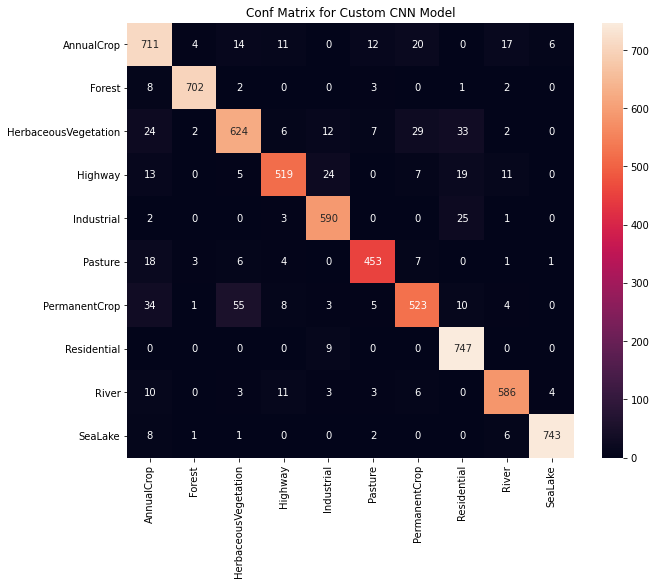

In [26]:
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat,annot=True,fmt='.0f');
plt.title("Conf Matrix for Custom CNN Model");

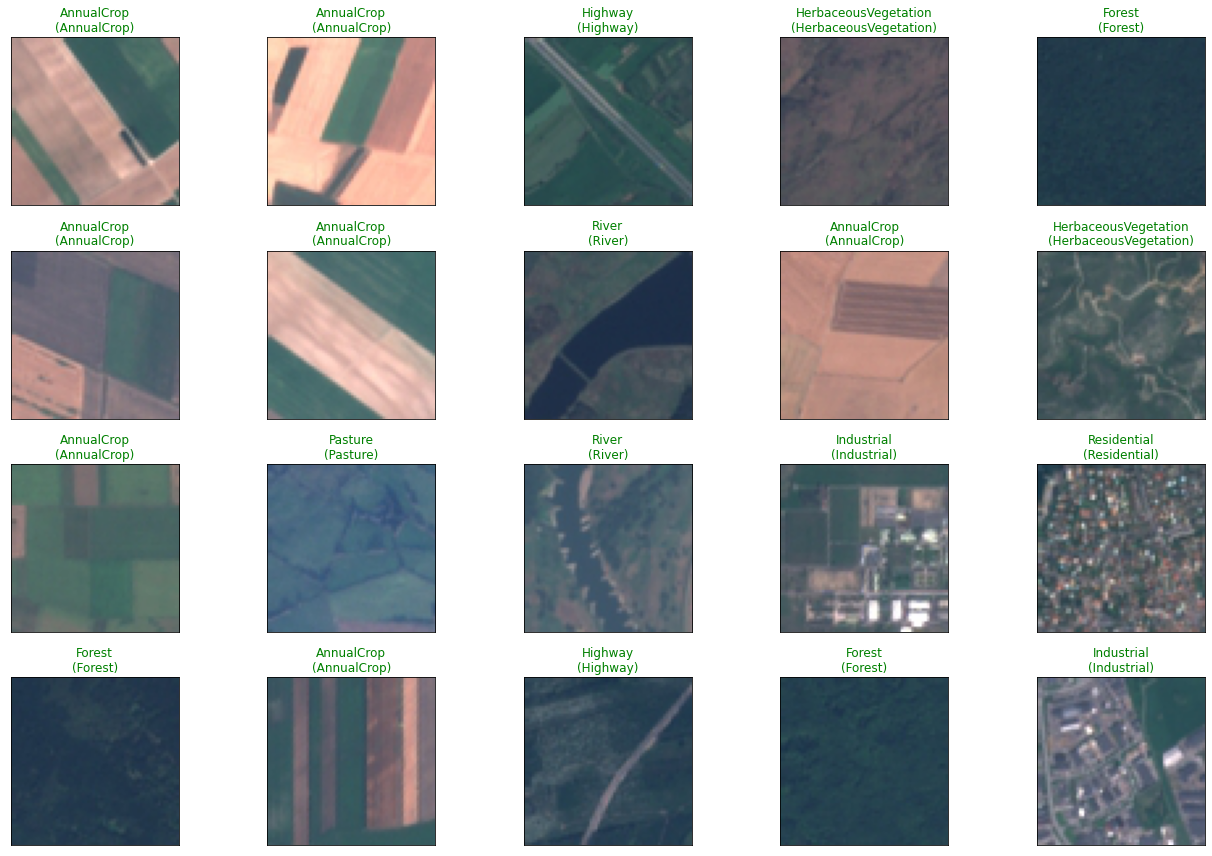

In [27]:
plot_predictions(true_classes, predictions, pred_generator, class_indices)

## Evaluating MobileNetV2 Model

In [28]:
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
pred_generator.reset()

predictions = mobilenet.predict_generator(pred_generator, steps=len(pred_generator.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = pred_generator.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Accuracy: 0.9672592592592593
F1 Score: 0.9663169347378489
Precision Score: 0.9679198746957383
Recall Score: 0.9653501864669239


Precision    Recall   F-Score  Support
AnnualCrop             0.953634  0.957233  0.955430    795.0
Forest                 0.988827  0.986072  0.987448    718.0
HerbaceousVegetation   0.936031  0.970230  0.952824    739.0
Highway                0.994575  0.919732  0.955691    598.0
Industrial             0.951788  0.985507  0.968354    621.0
Pasture                0.980892  0.937120  0.958506    493.0
PermanentCrop          0.950321  0.922240  0.936069    643.0
Residential            0.985602  0.996032  0.990789    756.0
River                  0.949309  0.987220  0.967894    626.0
SeaLake                0.988220  0.992116  0.990164    761.0

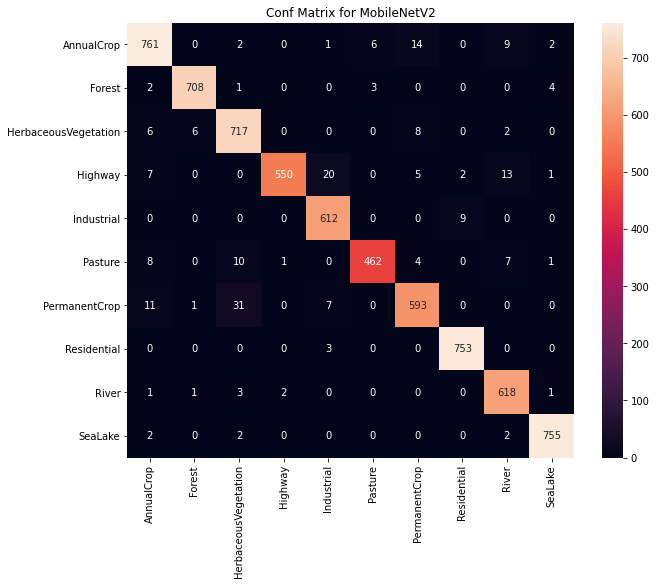

In [29]:
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat,annot=True,fmt='.0f');
plt.title("Conf Matrix for MobileNetV2");

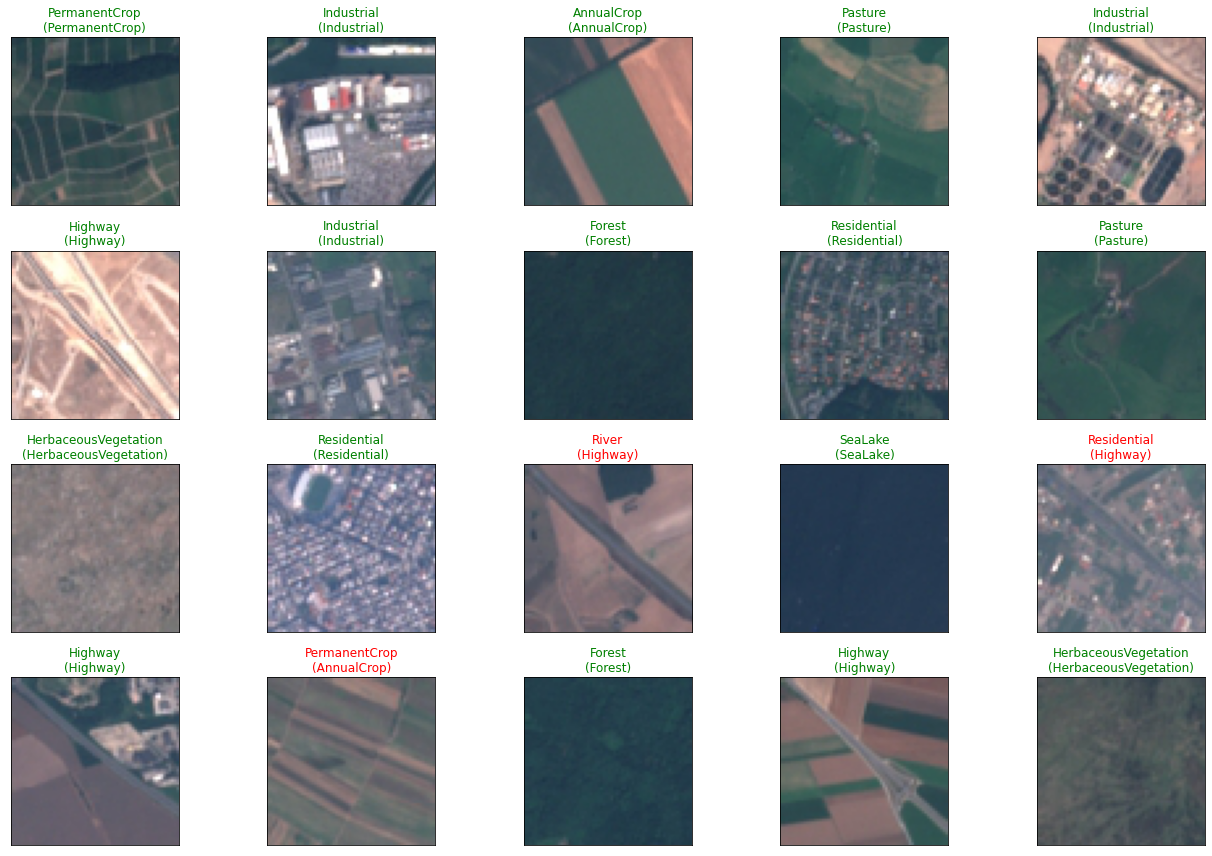

In [30]:
plot_predictions(true_classes, predictions, pred_generator, class_indices)
plt.savefig("sample_output.png")

## Evaluating ResNet101V2 Model

In [31]:
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
pred_generator.reset()

predictions = resnet.predict_generator(pred_generator, steps=len(pred_generator.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = pred_generator.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Accuracy: 0.8878518518518519
F1 Score: 0.8889952852370033
Precision Score: 0.9062866976334949
Recall Score: 0.8860357902074307


Precision    Recall   F-Score  Support
AnnualCrop             0.961864  0.856604  0.906188    795.0
Forest                 0.785317  0.983287  0.873222    718.0
HerbaceousVegetation   0.957968  0.740189  0.835115    739.0
Highway                0.966431  0.914716  0.939863    598.0
Industrial             0.968191  0.784219  0.866548    621.0
Pasture                0.930394  0.813387  0.867965    493.0
PermanentCrop          0.799736  0.944012  0.865906    643.0
Residential            0.738281  1.000000  0.849438    756.0
River                  0.956169  0.940895  0.948470    626.0
SeaLake                0.998514  0.883049  0.937238    761.0

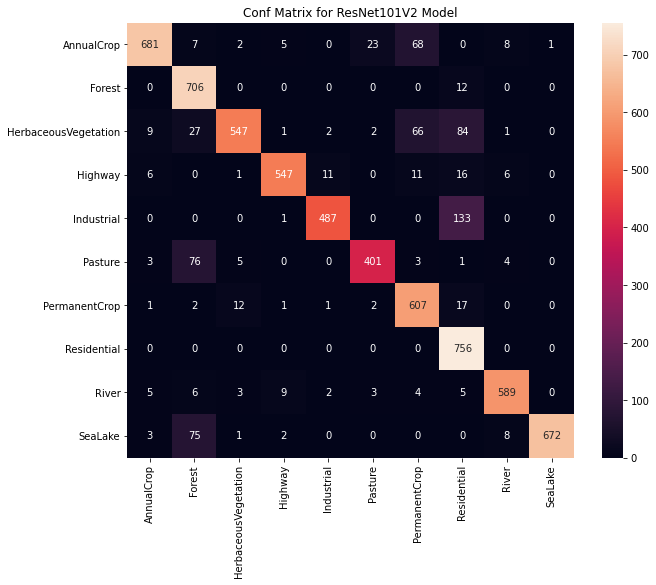

In [32]:
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat,annot=True,fmt='.0f');
plt.title("Conf Matrix for ResNet101V2 Model");

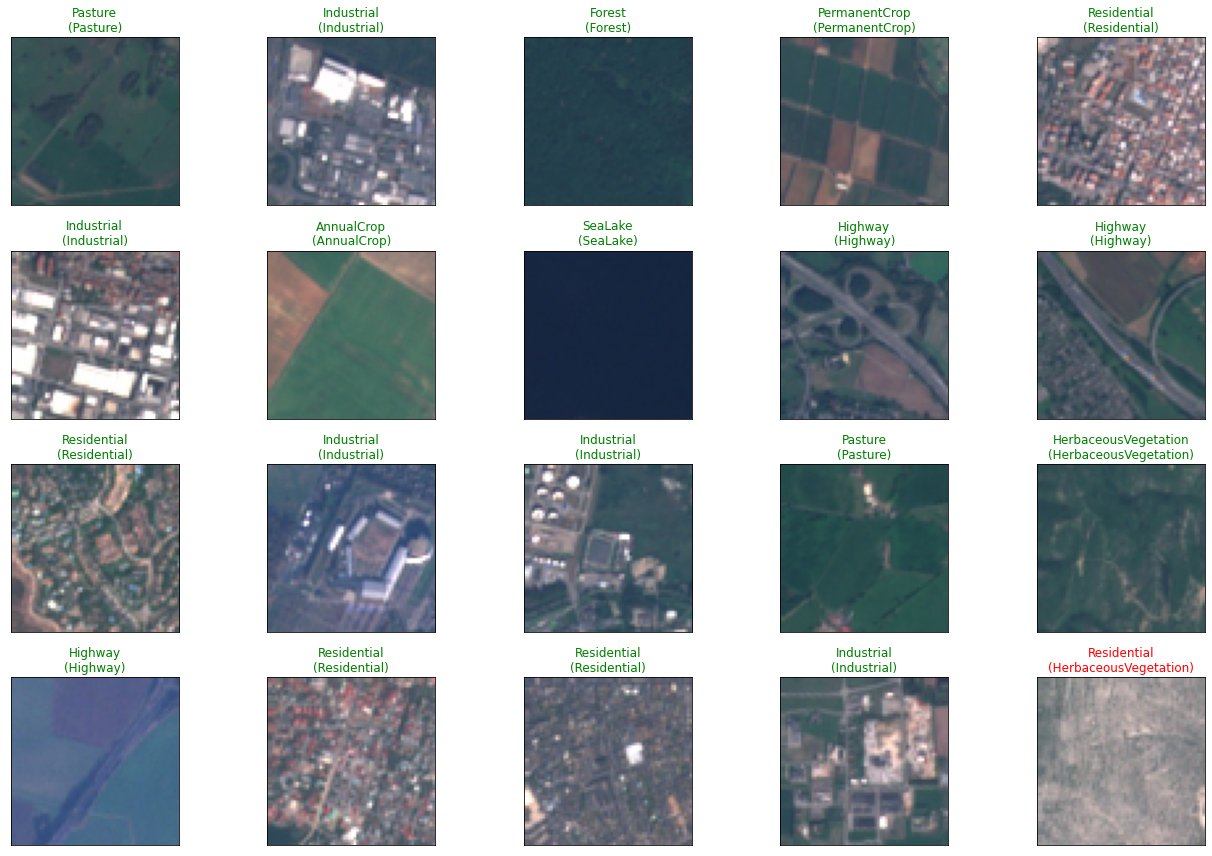

In [33]:
plot_predictions(true_classes, predictions, pred_generator, class_indices)
plt.savefig("sample_output.png")

# LIME

In [34]:
from lime import lime_image
import cv2
from PIL import Image
from skimage.segmentation import mark_boundaries
explainer = lime_image.LimeImageExplainer()

In [35]:
!mkdir custom_model
!mkdir mobilenet
!mkdir resnet

In [36]:
def get_random_image():
    actual_label = random.choice(LABELS)
    dir_path = os.path.join(TEST_DIR,actual_label)
    img = np.random.choice(os.listdir(dir_path))
    return (os.path.join(dir_path,img),actual_label)

In [37]:
TESTS = 2
REPS = 5
MODELS = [custom_model,mobilenet,resnet]
MODEL_NAMES = ["custom_model","mobilenet","resnet"]


for model_i,MODEL in enumerate(MODELS):
    for rep in range(REPS):
        print("-"*20,MODEL_NAMES[model_i],rep+1,"-"*20)
        fig, axs = plt.subplots(TESTS, 5,figsize=(20,5*TESTS))
        for i in range(TESTS):
            actual_label,pred_label = 1,2
            while actual_label != pred_label:
                img_path,actual_label = get_random_image()
                img = mpimg.imread(img_path)
                img_rescale = img/255
                explanation = explainer.explain_instance(img_rescale, MODEL.predict, top_labels=3, hide_color=0, num_samples=1000)
                temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
                img_new = np.expand_dims(img_rescale,0)
                pred_label = LABELS[resnet.predict(img_new).argmax()]
            
            # Main image
            axs[i,0].imshow(img)
            axs[i,0].set_title("P:{}; A:{}".format(pred_label, actual_label),
                             color=("green" if pred_label == actual_label else "red"))    
            axs[i,0].axison = False 
            
            # Mask Intersection image
            axs[i,1].imshow(mark_boundaries(temp, mask))
            axs[i,1].set_title("Mask Intersection")
            axs[i,1].axison = False 
            
            # Most Important Regions
            axs[i,2].imshow(img)
            axs[i,2].imshow(mask, cmap='GnBu', alpha=0.9*(mask==1)) 
            axs[i,2].set_title("Most Important Regions")
            axs[i,2].axison = False 
            
            # Least Important Regions
            axs[i,3].imshow(img)
            axs[i,3].imshow(mask, cmap='coolwarm_r', alpha=0.9*(mask==0)) 
            axs[i,3].set_title("Least Important Regions")
            axs[i,3].axison = False 
            
            # Colorbar
            ind =  explanation.top_labels[0]
            #Map each explanation weight to the corresponding superpixel
            dict_heatmap = dict(explanation.local_exp[ind])
            heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
            #Plot. The visualization makes more sense if a symmetrical colorbar is used.
            im = axs[i, 4].imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
            plt.colorbar(im, ax=axs[i, 4])
            axs[i,4].set_title("Importance Colormap")
        
        
        plt.tight_layout()
        plt.savefig(f"/kaggle/working/{MODEL_NAMES[model_i]}/LIME{rep}.png")
        # plt.show()

-------------------- custom_model 1 --------------------


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |##################################

-------------------- custom_model 2 --------------------


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


-------------------- custom_model 3 --------------------


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |##################################

-------------------- custom_model 4 --------------------


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |##################################

-------------------- custom_model 5 --------------------


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


-------------------- mobilenet 1 --------------------


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


-------------------- mobilenet 2 --------------------


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


-------------------- mobilenet 3 --------------------


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


-------------------- mobilenet 4 --------------------


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


-------------------- mobilenet 5 --------------------


100% |########################################################################|
100% |########################################################################|


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


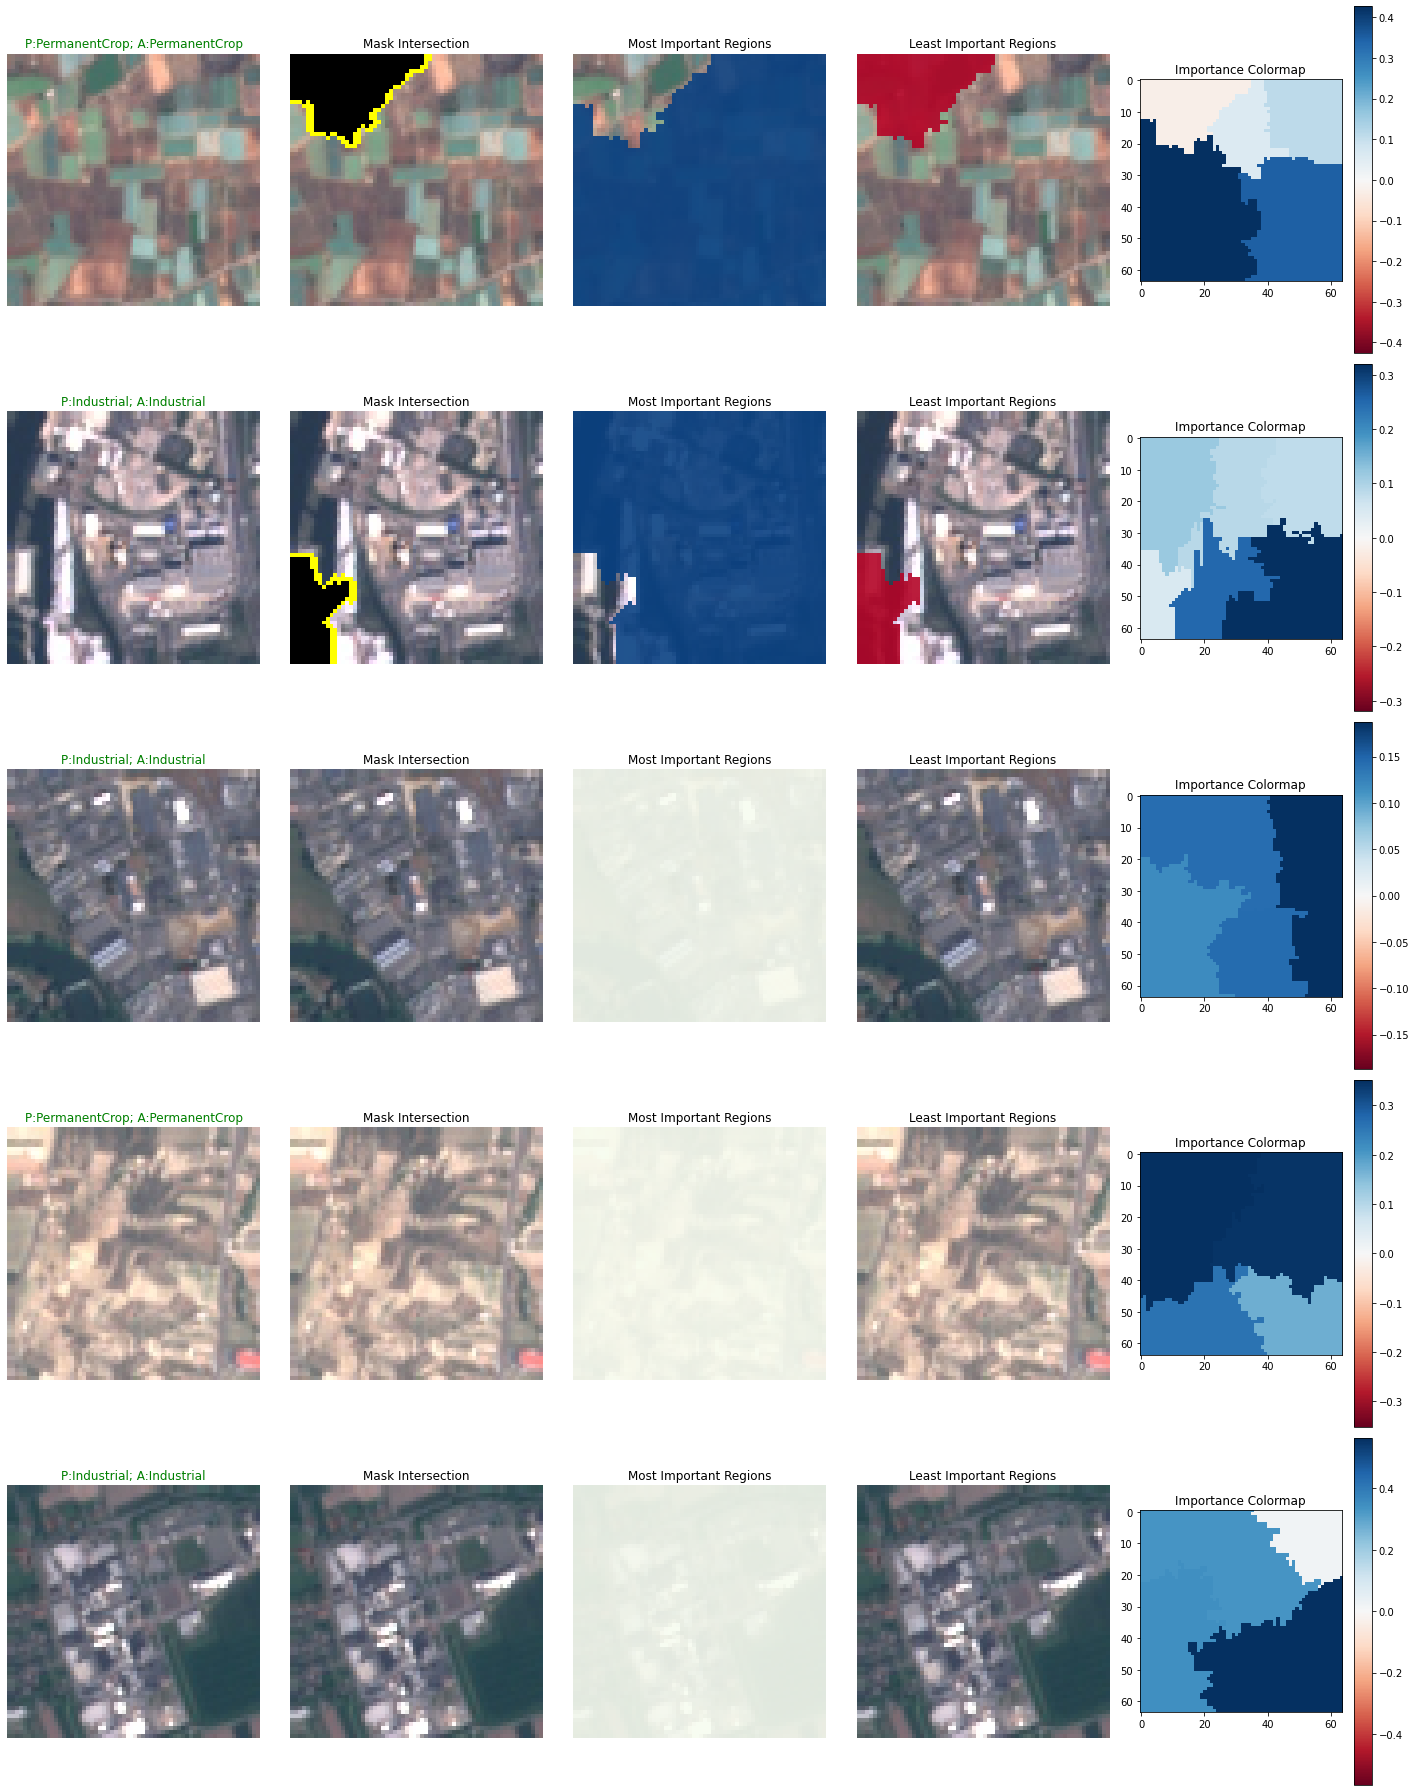

In [38]:
# RANDOM_TESTS = []
# ACTUAL_LABELS = []
TESTS = 5
MODEL = mobilenet

# for i in range(TESTS):
#     actual_label = random.choice(LABELS)
#     dir_path = os.path.join(TEST_DIR,actual_label)
#     img = np.random.choice(os.listdir(dir_path))
#     RANDOM_TESTS.append(os.path.join(dir_path,img))
#     ACTUAL_LABELS.append(actual_label)

fig, axs = plt.subplots(TESTS, 5,figsize=(20,5*TESTS))
for i in range(TESTS):
    actual_label,pred_label = 1,2
    while actual_label != pred_label:
        img_path,actual_label = get_random_image()
        img = mpimg.imread(img_path)
        img_rescale = img/255
        explanation = explainer.explain_instance(img_rescale, MODEL.predict, top_labels=3, hide_color=0, num_samples=1000)
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
        img_new = np.expand_dims(img_rescale,0)
        pred_label = LABELS[resnet.predict(img_new).argmax()]
    
    # Main image
    axs[i,0].imshow(img)
    axs[i,0].set_title("P:{}; A:{}".format(pred_label, actual_label),
                     color=("green" if pred_label == actual_label else "red"))    
    axs[i,0].axison = False 
    
    # Mask Intersection image
    axs[i,1].imshow(mark_boundaries(temp, mask))
    axs[i,1].set_title("Mask Intersection")
    axs[i,1].axison = False 
    
    # Most Important Regions
    axs[i,2].imshow(img)
    axs[i,2].imshow(mask, cmap='GnBu', alpha=0.9*(mask==1)) 
    axs[i,2].set_title("Most Important Regions")
    axs[i,2].axison = False 
    
    # Least Important Regions
    axs[i,3].imshow(img)
    axs[i,3].imshow(mask, cmap='coolwarm_r', alpha=0.9*(mask==0)) 
    axs[i,3].set_title("Least Important Regions")
    axs[i,3].axison = False 
    
    # Colorbar
    ind =  explanation.top_labels[0]
    #Map each explanation weight to the corresponding superpixel
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
    #Plot. The visualization makes more sense if a symmetrical colorbar is used.
    im = axs[i, 4].imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar(im, ax=axs[i, 4])
    axs[i,4].set_title("Importance Colormap")


plt.tight_layout()
plt.savefig("LIME xAI")
plt.show()

In [39]:

# def predict_fn(model,image):
# #     for image in images:
# #         if(image.shape[2]==3):
# #             image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# #         image = cv2.resize(image, (150,150))
#     image = ((image.astype(float))/255)
#     image = image.reshape((-1,150,150,3))
#     return model.predict(image)

# # cv2
# im = cv2.imread("/kaggle/input/lulc-eurosat/training/AnnualCrop/AnnualCrop_10.jpg")

# # pil
# image = Image.open("/kaggle/input/lulc-eurosat/training/AnnualCrop/AnnualCrop_10.jpg")
# image_np = np.asarray(image)/255

In [40]:
# explainer = lime_image.LimeImageExplainer()

# # explanation = explainer.explain_instance(im.astype('double'), resnet.predict, top_labels=5, hide_color=0, num_samples=1000)
# explanation = explainer.explain_instance(image_np, resnet.predict, top_labels=5, hide_color=0, num_samples=1000)
# temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)


# plt.subplots(1,5,figsize=(30,10))

# plt.subplot(1,5,1)
# plt.imshow(image)

# plt.subplot(1,5,2)
# plt.imshow(mark_boundaries(temp, mask))
# plt.title("Top 5 superpixels that are most positive towards the class (rest of the image hidden)")

# plt.subplot(1,5,3)
# plt.imshow(image)
# plt.imshow(mask, cmap='GnBu', alpha=0.9*(mask==1)) 
# plt.title("Most Important Regions")

# plt.subplot(1,5,4)
# plt.imshow(image)
# plt.imshow(mask, cmap='coolwarm_r', alpha=0.9*(mask==0)) 
# plt.title("Least Important Regions")

# plt.subplot(1,5,5)
# ind =  explanation.top_labels[0]
# #Map each explanation weight to the corresponding superpixel
# dict_heatmap = dict(explanation.local_exp[ind])
# heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
# #Plot. The visualization makes more sense if a symmetrical colorbar is used.
# plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
# plt.colorbar()

# plt.axis("off")
# plt.tight_layout()